### Setup - imports, constants, download of data from GitHub

In [1]:
import os
import glob
import tensorflow as tf
import tensorflow.keras.models as tfm
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tfc
import tensorflow.keras.utils as tfu
import sklearn.model_selection as skms
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import time
import functools
import IPython.display as ipd
import pandas as pd

os.system("pip install keras-flops > /dev/null")
import keras_flops as kf

SEED = 42
IMAGE_HEIGHT = 20
IMAGE_WIDTH = 20
IMAGE_WIDTH_HEIGHT_INDEX = IMAGE_WIDTH - 1
SAMPLES_PER_MEASUREMENT = 119
LINES_PER_MEASUREMENT = SAMPLES_PER_MEASUREMENT + 1
NUMBER_OF_LABELS = 5
LABELS = ["Alohomora", "Arresto Momentum", "Avada Kedavra", "Locomotor", "Revelio"]

LARGE_DATA_SET = True  # set to True to train on larger data set, otherwise smaller will be used
data_set_dir = "data_large" if LARGE_DATA_SET else "data"

# create input/output directories and download data
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs(data_set_dir, exist_ok=True)

if not os.path.isfile(f"{data_set_dir}/spells.zip"):
    os.system(f"wget -P {data_set_dir}/ https://github.com/xmihol00/robust_magic_wand/raw/main/{data_set_dir}/spells.zip")
    os.system(f"unzip {data_set_dir}/spells.zip")

2025-09-17 21:09:58.115012: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 21:09:58.116398: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 21:09:58.149760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 21:09:58.150815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 21:09:58.772941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Functions for data processing, creation of data sets and model analysis

In [2]:
def get_stroke_samples(data):
    angle_samples = np.zeros((SAMPLES_PER_MEASUREMENT, 3))
    stroke_samples = np.zeros((SAMPLES_PER_MEASUREMENT, 2))
    rows_of_samples = [list(map(lambda x: float(x), line.split(','))) for line in data.split('\n') if line] # convert each line to lists of floats

    for i in range(0, len(rows_of_samples), SAMPLES_PER_MEASUREMENT): 
        measurment = np.array(rows_of_samples[i: i+SAMPLES_PER_MEASUREMENT])
        acceleration_average = np.average(measurment[:, 0:3], axis=0)

        # calcualte angle
        previous_angle = np.zeros(3)
        for j, gyro_sample in enumerate(measurment[:, 3:6]):
            angle_samples[j] = previous_angle + gyro_sample / SAMPLES_PER_MEASUREMENT
            previous_angle = angle_samples[j]     
        angle_avg = np.average(angle_samples, axis=0) # average angle

        # calculate stroke
        acceleration_magnitude = np.sqrt(acceleration_average.dot(acceleration_average.T)) # dot product insted of squaring
        acceleration_magnitude += (acceleration_magnitude < 0.0001) * 0.0001 # prevent division by 0
        normalzied_acceleration = acceleration_average / acceleration_magnitude
        normalized_angle = angle_samples - angle_avg
        stroke_samples[:, 0] = -normalzied_acceleration[1] * normalized_angle[:, 1] - normalzied_acceleration[2] * normalized_angle[:, 2]
        stroke_samples[:, 1] =  normalzied_acceleration[1] * normalized_angle[:, 2] - normalzied_acceleration[2] * normalized_angle[:, 1]
        yield stroke_samples

def laod_dataset(directory, one_hot=True, seed=SEED):
    data = ""
    labels = []
    for i, file_name in enumerate(sorted(glob.glob(f"{directory}/*.csv"))): # sort the labels alphabetically
        file = open(file_name, "r")
        file.readline() # skip header
        read_lines = file.read()
        labels += [i] * (read_lines.count("\n") // LINES_PER_MEASUREMENT)
        data += read_lines
        file.close()

    arrays = np.zeros((len(labels), 2 * SAMPLES_PER_MEASUREMENT), dtype=np.float32)
    colors = np.linspace(255 - 2 * SAMPLES_PER_MEASUREMENT + 2, 255, SAMPLES_PER_MEASUREMENT) / 255
    images = np.zeros((len(labels), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

    for i, stroke_samples in enumerate(get_stroke_samples(data)): 
        stroke_samples -= np.min(stroke_samples, axis=0) # make samples in range from 0 to x
        stroke_samples /= np.max(stroke_samples, axis=0) # normalize values from 0 to 1
        arrays[i] = stroke_samples.reshape(-1)
        
        # rasterize stroke
        pixels = np.round(stroke_samples * IMAGE_WIDTH_HEIGHT_INDEX, 0).astype(np.uint8) # normalize samples to the whole image
        image = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT))
        image[pixels[:, 1], pixels[:, 0]] = colors
        images[i] = image.reshape(IMAGE_WIDTH, IMAGE_HEIGHT, 1).astype(np.float32)


    both_variants = [skms.train_test_split(arrays, labels, test_size=0.2, random_state=seed),
                     skms.train_test_split(images, labels, test_size=0.2, random_state=seed)]

    for i in range(len(both_variants)):
        X_train, X_test, y_train, y_test = both_variants[i]
        y_test = np.array(y_test)
        if one_hot:
            # one-hot encoding of labels
            y_train = tfu.to_categorical(y_train, num_classes=5)
        both_variants[i] = (X_train, X_test, y_train, y_test)
       
    return both_variants

def representative_dataset(data_set):
    for sample in data_set:
        yield [np.expand_dims(sample, 0)]

def collect_model_summary(summary_line, model_dict):
    match = re.match(r"(.*?): ([\d,]+)", summary_line)
    if match:
        match = match.groups()
        model_dict[match[0].replace("params", "parameters")] = int(match[1].replace(',', ''))

### Model definition

In [3]:
hidden_activation = tf.keras.layers.LeakyReLU(0.1)
model_name = "CNN"

if model_name == "Dense":  # change to False to use the dense model
    droput_1 = 0.4
    droput_2 = 0.3
    droput_3 = 0.25

    model = tfm.Sequential([
        tfl.Dense(units=50, activation=hidden_activation),
        tfl.Dropout(droput_2),
        tfl.Dense(units=25, activation=hidden_activation),
        tfl.Dropout(droput_3),
        tfl.Dense(units=5, activation="softmax")
    ])

elif model_name == "CNN":
    model = tfm.Sequential([
        tfl.Conv2D(filters=8, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=16, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Conv2D(filters=32, kernel_size=(3, 3), activation=hidden_activation, padding="same"),
        tfl.MaxPool2D(),
        tfl.Flatten(),
        tfl.Dense(units=32, activation=hidden_activation),
        tfl.Dense(units=5, activation="softmax"),
    ])

2025-09-17 21:10:02.805056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-17 21:10:02.805639: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Load the data set

In [4]:
X_train, X_test, y_train, y_test = laod_dataset(data_set_dir)[model_name == "CNN"]

### Train with validation data set to get the relevant number of epochs needed for training

In [5]:
# make results reproduceable
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

results = {}

# get weights for the given seed
model.build(X_train.shape)
weights = model.get_weights()

# get the best number of epochs based on validation data set
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=2,
                    callbacks=[tfc.EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=False)]).history
epochs = len(history["loss"]) - 3
results["Epochs"] = epochs

Epoch 1/100
20/20 - 1s - loss: 1.5325 - accuracy: 0.5016 - val_loss: 1.4130 - val_accuracy: 0.6438 - 751ms/epoch - 38ms/step
Epoch 2/100
20/20 - 0s - loss: 1.2298 - accuracy: 0.6500 - val_loss: 0.9467 - val_accuracy: 0.7688 - 52ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6667 - accuracy: 0.8406 - val_loss: 0.4209 - val_accuracy: 0.8750 - 58ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.3367 - accuracy: 0.8859 - val_loss: 0.2393 - val_accuracy: 0.9312 - 54ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.2015 - accuracy: 0.9453 - val_loss: 0.1942 - val_accuracy: 0.9375 - 48ms/epoch - 2ms/step
Epoch 6/100
20/20 - 0s - loss: 0.1602 - accuracy: 0.9438 - val_loss: 0.2016 - val_accuracy: 0.9375 - 50ms/epoch - 2ms/step
Epoch 7/100
20/20 - 0s - loss: 0.1617 - accuracy: 0.9422 - val_loss: 0.1979 - val_accuracy: 0.9500 - 51ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.1153 - accuracy: 0.9672 - val_loss: 0.1732 - val_accuracy: 0.9500 - 55ms/epoch - 3ms/step
Epoch 9/100
20

### Train on the whole train data set

In [6]:
# reset the initialized weights
model.set_weights(weights)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
train_start = time.time()
model.fit(X_train, y_train, epochs=epochs, validation_split=0.0, batch_size=32, verbose=2)
results["Training time GPU"] = f"{(time.time() - train_start):.2f} s"

Epoch 1/9
25/25 - 0s - loss: 1.5253 - accuracy: 0.5175 - 466ms/epoch - 19ms/step
Epoch 2/9
25/25 - 0s - loss: 1.0791 - accuracy: 0.7163 - 41ms/epoch - 2ms/step
Epoch 3/9
25/25 - 0s - loss: 0.4323 - accuracy: 0.8938 - 40ms/epoch - 2ms/step
Epoch 4/9
25/25 - 0s - loss: 0.2265 - accuracy: 0.9225 - 41ms/epoch - 2ms/step
Epoch 5/9
25/25 - 0s - loss: 0.1717 - accuracy: 0.9450 - 43ms/epoch - 2ms/step
Epoch 6/9
25/25 - 0s - loss: 0.1324 - accuracy: 0.9563 - 41ms/epoch - 2ms/step
Epoch 7/9
25/25 - 0s - loss: 0.1050 - accuracy: 0.9688 - 40ms/epoch - 2ms/step
Epoch 8/9
25/25 - 0s - loss: 0.0914 - accuracy: 0.9737 - 39ms/epoch - 2ms/step
Epoch 9/9
25/25 - 0s - loss: 0.0833 - accuracy: 0.9775 - 44ms/epoch - 2ms/step


### Get the summary of the model

In [7]:
model.summary(print_fn=lambda x, y=results: collect_model_summary(x, y))
results["FLOPS"] = kf.get_flops(model, batch_size=1)

ipd.clear_output()

### Convert the model to TFLite

In [8]:
# convert the model without optimiziation (evaluation is not necessary, the results after conversion are the same)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
results_file = open(f"models/model.tflite", "wb")
results_file.write(tflite_model)
results_file.close()
results["Size"] = os.path.getsize(f"models/model.tflite")
del tflite_model

# convert the model with optimization 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = lambda x=X_train: representative_dataset(x)
tflite_model_opt = converter.convert()
results_file = open(f"models/model.tflite", "wb")
results_file.write(tflite_model_opt)
results_file.close()
results["Optimized size"] = os.path.getsize(f"models/model.tflite")
os.system(f'echo "const unsigned char model[] = {{" > models/model.h && cat models/model.tflite | xxd -i >> models/model.h && echo "}};" >> models/model.h && rm -f models/model.tflite')

ipd.clear_output()

### Predict the test data set using the full and optimized models

In [9]:
# predict and evaluate the prediction of the full model
predictions_full = model.predict(X_test, verbose=0)
predictions_full = np.argmax(predictions_full, axis=1)
results["Full model accuracy"] = f"{((predictions_full == y_test).sum() / y_test.shape[0] * 100):.2f} %"

# predict using the optimized model and evaluate the prediction
interpreter = tf.lite.Interpreter(model_content=tflite_model_opt)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
input_scale, input_zero_point = interpreter.get_output_details()[0]["quantization"]
predictions_opt = np.zeros((y_test.shape[0]))
for i, sample in enumerate(X_test):
    interpreter.set_tensor(input_index, np.expand_dims(sample / input_scale + input_zero_point, 0).astype(np.int8))
    interpreter.invoke()
    predictions_opt[i] = np.argmax(interpreter.get_tensor(output_index)[0]) # rescaling is not needed
results["Optimized model accuracy"] = f"{((predictions_opt == y_test).sum() / y_test.shape[0] * 100):.2f} %"

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Display the model statisctics

In [10]:
results

{'Epochs': 9,
 'Training time GPU': '0.84 s',
 'Total parameters': 10181,
 'Trainable parameters': 10181,
 'Non-trainable parameters': 0,
 'FLOPS': 537886,
 'Size': 45400,
 'Optimized size': 17264,
 'Full model accuracy': '95.00 %',
 'Optimized model accuracy': '94.50 %'}

### Plot the confusion matrices of the full and optimized models

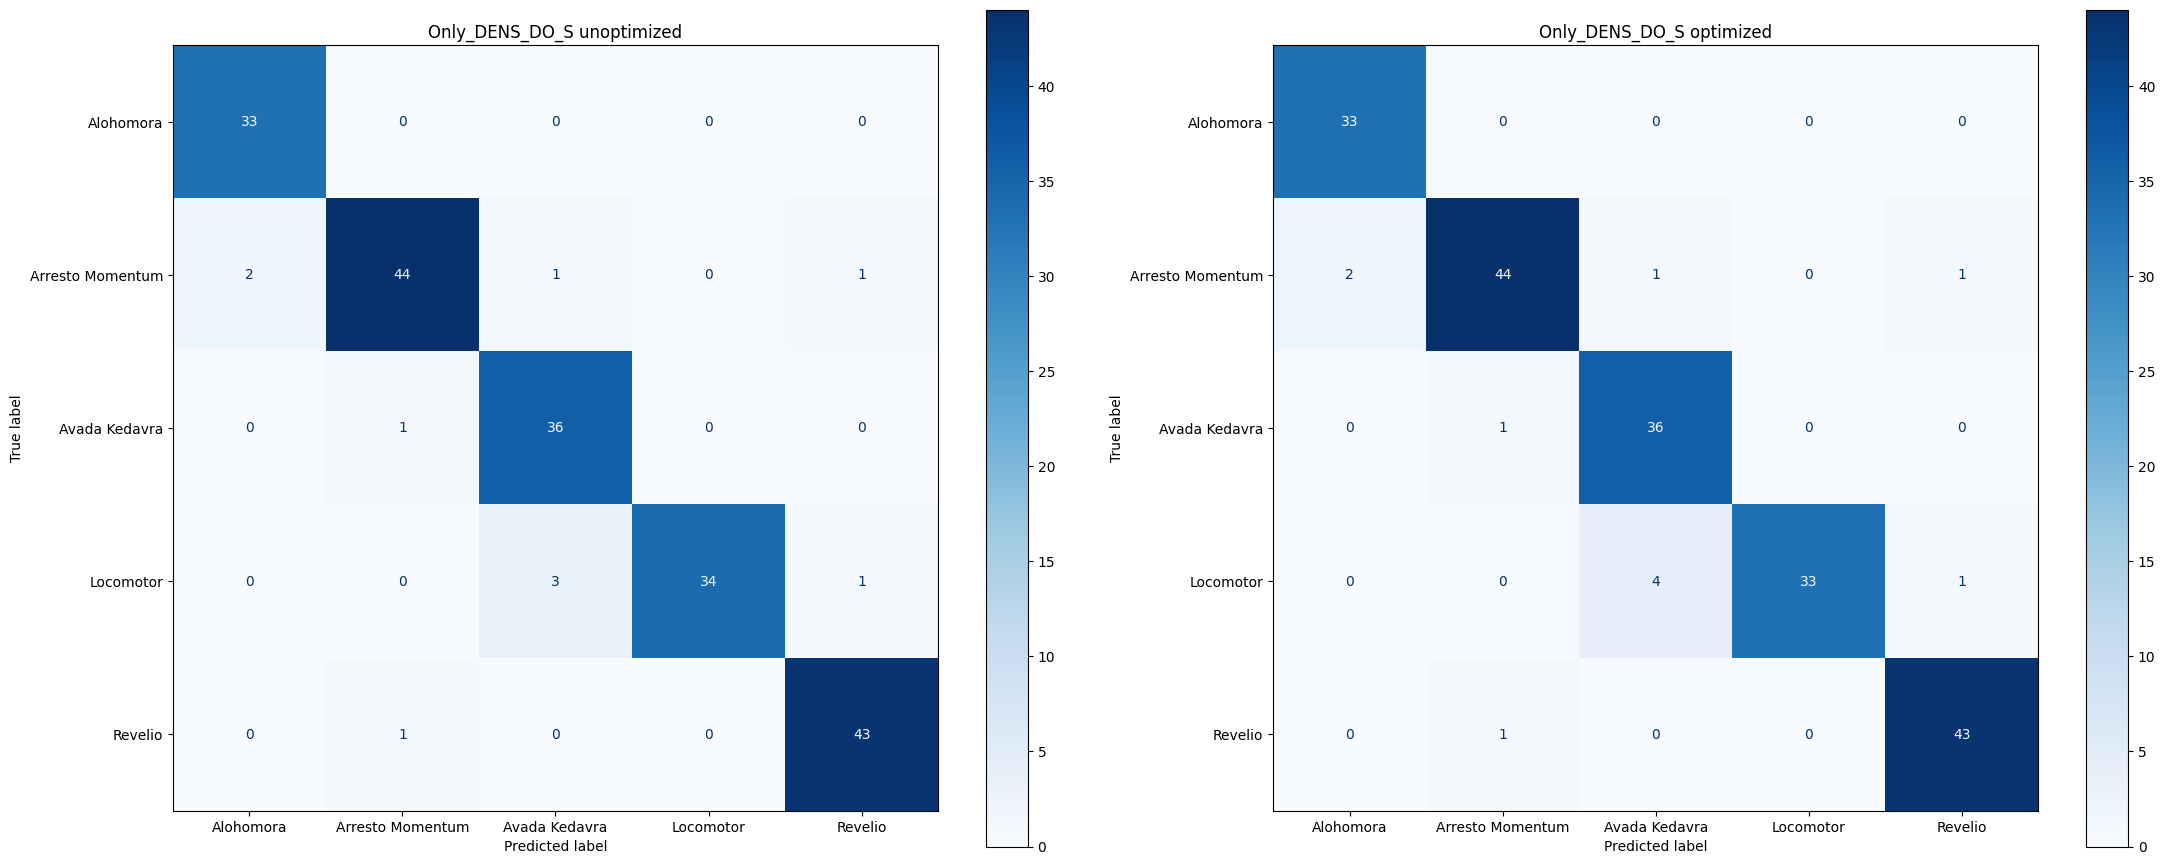

In [ ]:
figure, axis = plt.subplots(1, 2) # plot of the confusion matrix for selected models
figure.set_size_inches(22, 9)
axis_idx = 0
plt.subplots_adjust(left=0.085, bottom=0.04, right=1.02, top=0.97, hspace=0.15, wspace=0.15)

# plot the full model confusion metrix
confusion_matrix = tf.math.confusion_matrix(y_test, predictions_full).numpy()
confusion_matrix = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)
axis[0].set_title(f"{model_name} unoptimized")
confusion_matrix.plot(cmap="Blues", ax=axis[0])

# plot the confusuion matrix of the optimized model
confusion_matrix = tf.math.confusion_matrix(y_test, predictions_opt).numpy()
confusion_matrix = skm.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=LABELS)
axis[1].set_title(f"{model_name} optimized")
confusion_matrix.plot(cmap="Blues", ax=axis[1])

plt.savefig(f"figures/{model_name}", dpi=300)
plt.show()

### Move the model to Arduino code

In [12]:
# do that only on a local machine, if the file exist
if model_name == "CNN":
    os.system("cat models/model.h > arduino_2D_inference/model.h")
elif model_name == "Dense":
    os.system("cat models/model.h > arduino_1D_inference/model.h")    